In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pathlib
import numpy as np
from pyrosetta import *
from pyrosetta.rosetta import *

init('-mute all')

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2025 [Rosetta PyRosetta4.conda.ubuntu.cxx11thread.serialization.Ubuntu.python311.Release 2025.06+release.029c6a159b896477003a14f78f472d4cd2cead46 2025-02-04T15:14:13] retrieved from: http://www.pyrosetta.org


In [54]:
model_binder = [
    ('1', '0'),
    ('2', '0'),
    ('2', '1'),
    ('3', '2'),
]

idx = 3

name = 'dimer_trop2_human_binder_' + model_binder[idx][0] + '_model_' + model_binder[idx][1]
print('Analyzing ' + name)
path = './out_' + name

pt_files = list(pathlib.Path(path + '/stats').glob('*.pt'))
data_list = [torch.load(f) for f in pt_files]
print("\nLoaded statistics from", len(data_list),"structures:")
for key in data_list[0]:
    try:
        print('\t', key, data_list[0][key].size())
    except:
        print('\t', key, data_list[0][key])
print('Totalling', len(data_list)*data_list[0]['generated_sequences'].size()[0], 'sequences')

# because Torben is doing so, we will now average all probs
# This is to mitigate sampling effects, because the probs at each position change depending on which position was already fixed before
# Additionally we combine all relaxed structures into the average to incorporate some flexibility
all_probs = [data['sampling_probs'] for data in data_list]
all_probs = torch.cat(all_probs, dim=0)
print('\nCombined all probabilities into a tensor of size', all_probs.size())

mean_probs = torch.mean(all_probs, dim=0)
print('And averaged into', mean_probs.size())

wt_aa = data_list[0]['native_sequence']
max_probs, max_prob_aa = torch.max(mean_probs, dim=1)
# keep only postions where mpnn wants to change the amino acid
identity_mask = max_prob_aa != wt_aa
# keep only positions where mpnn has at least some uncertainty about the selection
prob_mask = max_probs < 0.95
# combine with or to keep positions where either something else gets selected or mpnn hat some uncertainty what to keep
change_mask = (identity_mask | prob_mask) & data_list[0]['chain_mask'].bool()

#mean_probs = mean_probs[change_mask]
#print('Masked to:', mean_probs.size())

# the wildtype sequence is always the same as the only input difference is the relax result
seq_file = path + '/seqs/' + name + '_0001.fa'
with open(seq_file, 'r') as f:
    lines = f.readlines()
    wt_seq = lines[1].strip().split(':')
    seq_chain_lens = np.array([len(seq) for seq in wt_seq])
    chain_start_idx = np.cumsum(np.insert(seq_chain_lens, 0, 0))
    print("Length of chains:", seq_chain_lens)
    print("Chain start indices:", chain_start_idx)
    wt_seq = list(''.join(wt_seq))
    wt_seq = np.array(wt_seq)
print('\nNative sequence length:', wt_seq.shape)

Analyzing dimer_trop2_human_binder_3_model_2

Loaded statistics from 7 structures:
	 generated_sequences torch.Size([100, 648])
	 sampling_probs torch.Size([100, 648, 20])
	 log_probs torch.Size([100, 648, 21])
	 decoding_order torch.Size([100, 648])
	 native_sequence torch.Size([648])
	 mask torch.Size([648])
	 chain_mask torch.Size([648])
	 seed 420
	 temperature 0.1
Totalling 700 sequences

Combined all probabilities into a tensor of size torch.Size([700, 648, 20])
And averaged into torch.Size([648, 20])
Length of chains: [248 248  76  76]
Chain start indices: [  0 248 496 572 648]

Native sequence length: (648,)


In [55]:
# Create the final sequence by selecting only Max prob res
AA = np.array(list('ACDEFGHIKLMNPQRSTVWYX'))
consensus_seq_idx = max_prob_aa[chain_start_idx[2]:chain_start_idx[3]]
static_aa_mask = (data_list[0]['chain_mask'][chain_start_idx[2]:chain_start_idx[3]] - 1).abs()
binder_wt_aa = wt_aa[chain_start_idx[2]:chain_start_idx[3]]
static_aa = binder_wt_aa * static_aa_mask
full_consensus_seq_idx = static_aa + consensus_seq_idx
consensus_seq = ''.join(AA[full_consensus_seq_idx])
wt_chain_seq = ''.join(wt_seq[chain_start_idx[2]:chain_start_idx[3]])
print('Wildtype binder :', wt_chain_seq)
print('Consensus binder:', consensus_seq)

Wildtype binder : MQIMVWTEKGKWIGLEVEPSDTIENVKAKIQDKEGIPPDQQRLIWAGKQLEDGRTLSDYNIEIHTWLPLELRLRAA
Consensus binder: MRIMVWDEKGKWIGLEVEPSDTIAQVKEKIQEKEGIPPEKQRLIWAGKELEDSKTLADYNIKDGTWLPLRIVDPAA


In [56]:
# thread sequence
pose = pose_from_file(path + '/packed/' + name + '_0001_packed_1_1.pdb')
chain_start = chain_start_idx[2]
chain_stop = chain_start + seq_chain_lens[2]
print(chain_start, chain_stop)

rsd_set = pose.residue_type_set_for_pose( core.chemical.FULL_ATOM_t )

restype_1to3 = {
    "A": "ALA",
    "R": "ARG",
    "N": "ASN",
    "D": "ASP",
    "C": "CYS",
    "Q": "GLN",
    "E": "GLU",
    "G": "GLY",
    "H": "HIS",
    "I": "ILE",
    "L": "LEU",
    "K": "LYS",
    "M": "MET",
    "F": "PHE",
    "P": "PRO",
    "S": "SER",
    "T": "THR",
    "W": "TRP",
    "Y": "TYR",
    "V": "VAL",
}

for i in range(seq_chain_lens[2]):
    resi = i + chain_start + 1 # rosetta 1 indexing
    name1 = consensus_seq[i]
    new_res = core.conformation.ResidueFactory.create_residue( rsd_set.name_map( restype_1to3[name1] ) )
    pose.replace_residue( resi, new_res, True )

binder_pose = pose.split_by_chain(3)

#relax = protocols.relax.FastRelax()
#relax.constrain_relax_to_start_coords(True)
#relax.apply(binder_pose)

print(binder_pose.sequence())

496 572
MRIMVWDEKGKWIGLEVEPSDTIAQVKEKIQEKEGIPPEKQRLIWAGKELEDSKTLADYNIKDGTWLPLRIVDPAA


In [57]:
layer_sel = core.select.residue_selector.LayerSelector()
layer_sel.set_layers(True, False, False)
core_mask = layer_sel.apply(binder_pose)
layer_sel.set_layers(False, True, False)
boundary_mask = layer_sel.apply(binder_pose)
layer_sel.set_layers(False, False, True)
surface_mask = layer_sel.apply(binder_pose)

interface_mask = static_aa_mask
core_mask = torch.tensor(list(core_mask), dtype=int) & interface_mask.logical_not()
boundary_mask = torch.tensor(list(boundary_mask), dtype=int) & interface_mask.logical_not()
surface_mask = torch.tensor(list(surface_mask), dtype=int) & interface_mask.logical_not()
print(torch.sum(torch.stack([interface_mask, core_mask, boundary_mask, surface_mask]), dim=0))

binder_change_mask = change_mask[chain_start_idx[2]:chain_start_idx[3]]
interface_change_mask = interface_mask & binder_change_mask
core_change_mask = core_mask & binder_change_mask
boundary_change_mask = boundary_mask & binder_change_mask
surface_change_mask = surface_mask & binder_change_mask

print(torch.sum(interface_change_mask))
print(torch.sum(core_change_mask))
print(torch.sum(boundary_change_mask))
print(torch.sum(surface_change_mask))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
tensor(0)
tensor(0)
tensor(3)
tensor(27)


In [58]:
pos_res = ['R', 'H', 'K']
neg_res = ['D', 'E']

wt_binder_seq = wt_seq[chain_start_idx[2]:chain_start_idx[3]]
print(wt_binder_seq)
wt_pos_binder_mask = np.isin(wt_binder_seq, pos_res).astype(int)
wt_neg_binder_mask = np.isin(wt_binder_seq, neg_res).astype(int)
print(np.sum(wt_pos_binder_mask))
print(np.sum(wt_neg_binder_mask))

consensus_seq_arr = np.array(list(consensus_seq))
design_pos_binder_mask = np.isin(consensus_seq_arr, pos_res).astype(int)
design_neg_binder_mask = np.isin(consensus_seq_arr, neg_res).astype(int)

total_positive_charge = 0
total_negative_charge = 0

masks = {
    'interface' : interface_mask,
    'core     ' : core_mask,
    'boundary ' : boundary_mask,
    'surface  ' : surface_mask,
}

print('\t\twt+\twt-\tdes+\tdes-')
for name, mask in masks.items():
    pos_charge_wt = np.sum(wt_pos_binder_mask*mask.numpy())
    neg_charge_wt = np.sum(wt_neg_binder_mask*mask.numpy())
    pos_charge_des = np.sum(design_pos_binder_mask*mask.numpy())
    neg_charge_des = np.sum(design_neg_binder_mask*mask.numpy())

    print(name + '\t' + '\t'.join([str(x) for x in [pos_charge_wt, neg_charge_wt, pos_charge_des, neg_charge_des]]))

['M' 'Q' 'I' 'M' 'V' 'W' 'T' 'E' 'K' 'G' 'K' 'W' 'I' 'G' 'L' 'E' 'V' 'E'
 'P' 'S' 'D' 'T' 'I' 'E' 'N' 'V' 'K' 'A' 'K' 'I' 'Q' 'D' 'K' 'E' 'G' 'I'
 'P' 'P' 'D' 'Q' 'Q' 'R' 'L' 'I' 'W' 'A' 'G' 'K' 'Q' 'L' 'E' 'D' 'G' 'R'
 'T' 'L' 'S' 'D' 'Y' 'N' 'I' 'E' 'I' 'H' 'T' 'W' 'L' 'P' 'L' 'E' 'L' 'R'
 'L' 'R' 'A' 'A']
11
13
		wt+	wt-	des+	des-
interface	4	1	4	1
core     	0	0	0	0
boundary 	2	2	2	2
surface  	5	10	6	12


20
torch.Size([3, 20])
torch.Size([27, 20])


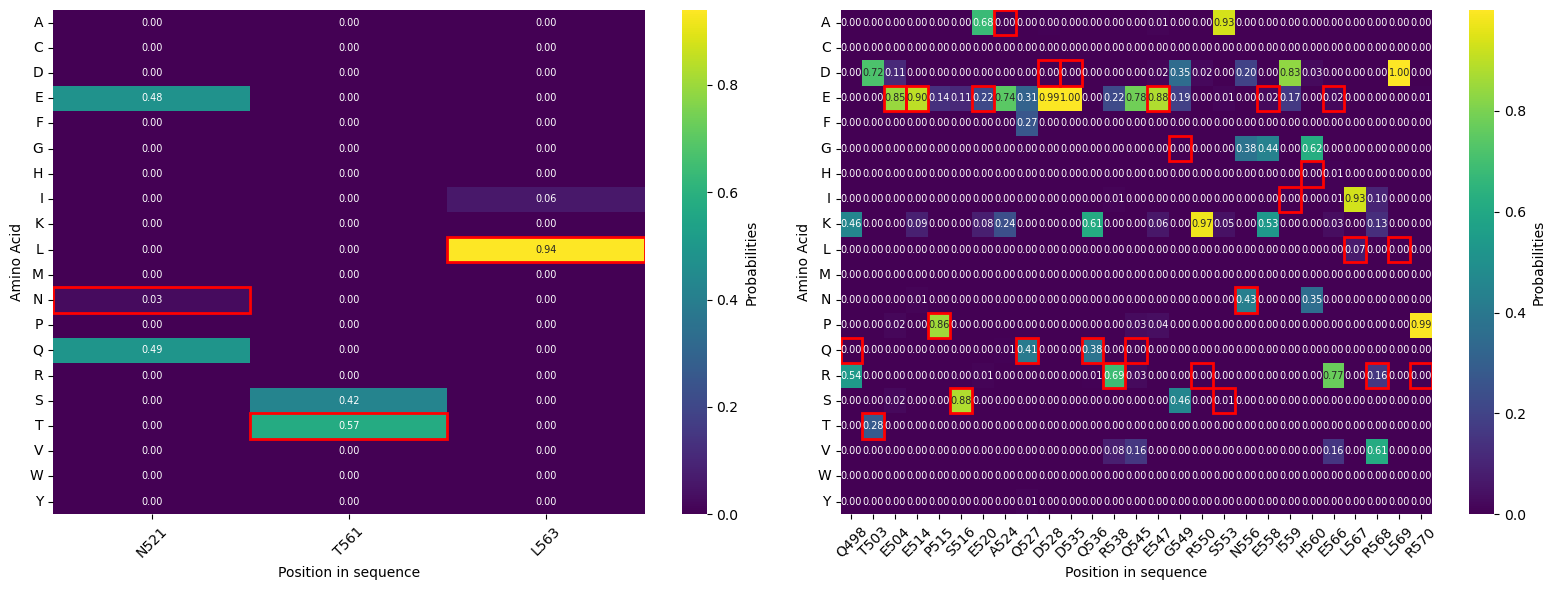

In [59]:
AA = 'ACDEFGHIKLMNPQRSTVWY'
print(len(AA))
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for idx, mask in enumerate([boundary_change_mask, surface_change_mask]):
    probs = mean_probs[chain_start_idx[2]:chain_start_idx[3]]
    probs = probs[mask.bool()]
    print(probs.size())
    sns.heatmap(
        probs.T, 
        ax=ax[idx], 
        cbar_kws={'label': 'Probabilities'}, 
        cmap='viridis',
        annot=True,
        fmt='.2f',
        annot_kws={'size': 7},
    )
    ax[idx].set_xlabel('Position in sequence')
    masked_wt_des_ind = np.where(mask)[0] + 1 + chain_start_idx[2]
    masked_wt_des_seq = wt_binder_seq[mask.bool()]
    tick_labels = zip(masked_wt_des_ind, masked_wt_des_seq)
    ax[idx].set_xticks(np.array(list(range(len(masked_wt_des_ind))))+0.5, [f'{aa}{pos}' for pos, aa in tick_labels],
        rotation=45,)

    ax[idx].set_ylabel('Amino Acid')
    ax[idx].set_yticks(np.arange(len(AA))+0.5);
    ax[idx].set_yticklabels(list(AA), rotation=0);

    for j, aa in enumerate(masked_wt_des_seq):
        aa_idx = AA.index(aa)
        ax[idx].add_patch(
            plt.Rectangle(
                (j, aa_idx), 
                width=1, 
                height=1,
                fill=False, 
                edgecolor='red', 
                lw=2
            )
        )

plt.tight_layout()
fig.savefig(f'figures/{name}_probs_heatmap.png', dpi=300)